In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import MACCSkeys, AllChem

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [7]:
import deepchem

AttributeError: module 'deepchem' has no attribute 'utils'

In [8]:
import sys
sys.path

['',
 '/home/honda/anaconda3/lib/python36.zip',
 '/home/honda/anaconda3/lib/python3.6',
 '/home/honda/anaconda3/lib/python3.6/lib-dynload',
 '/home/honda/anaconda3/lib/python3.6/site-packages',
 '/home/honda/anaconda3/lib/python3.6/site-packages/IPython/extensions',
 '/home/honda/.ipython']

In [2]:
df_sol = pd.read_csv('data/solubility.csv')
df_sol.head()

,SMILES,unknown,solubility,processed_smiles
0,O=C(C)N,60-35-5,1.58,O = C ( C ) N
1,NNC,60-34-4,1.34,N N C
2,O=C(C)O,64-19-7,1.22,O = C ( C ) O
3,N1CCCC1,123-75-1,1.15,N 1 C C C C 1
4,O=C(N)NO,127-07-1,1.12,O = C ( N ) N O


# Solubility regression

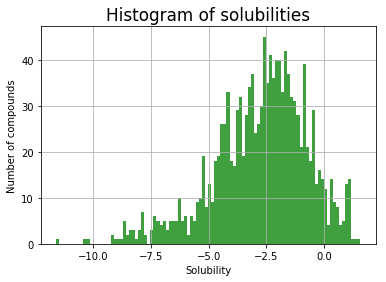

In [4]:
sol = df_sol['solubility'].values 
plt.hist(sol, 100, facecolor='green', alpha=0.75)
plt.rcParams["font.size"]=14
plt.xlabel('Solubility')
plt.ylabel('Number of compounds')
plt.title('Histogram of solubilities')
plt.grid()
plt.show()

In [6]:
def bit2np(bitvector):
    bitstring = bitvector.ToBitString()
    intmap = map(int, bitstring)
    return np.array(list(intmap))

In [25]:
smiles = df_sol["SMILES"].values
sol = df_sol['solubility'].values
N = len(smiles)
print("{} molecules".format(N))
X,y = [],[]
for i in range(N):
    mol = Chem.MolFromSmiles(smiles[i])
    if mol is None:
        print(i)
        continue
    
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024) # Morgan (Similar to ECFP4)
    #fp = AllChem.GetMACCSKeysFingerprint(mol) # MACCS Keys
    X.append(bit2np(fp))
    #X.append(smiles[i])
    y.append(sol[i])
X = np.array(X)
y = np.array(y)

1290 molecules
175


In [26]:
X_train,X_test,y_train,y_test = train_test_split(X, y)
print('Train', X_train.shape)
print('Test', X_test.shape)

Train (966, 1024)
Test (323, 1024)


# Prediction

In [27]:
RF = RandomForestRegressor()
RF.fit(X_train, y_train)

y_train_pred = RF.predict(X_train)
print("Train R2: {:.4f}".format(r2_score(y_train, y_train_pred)))
print("Train MSE: {:.4f}".format(mean_squared_error(y_train, y_train_pred)))

y_pred = RF.predict(X_test)
print("Test R2: {:.4f}".format(r2_score(y_test, y_pred)))
print("Test MSE: {:.4f}".format(mean_squared_error(y_test, y_pred)))

Train R2: 0.9267
Train MSE: 0.3062
Test R2: 0.6524
Test MSE: 1.3847


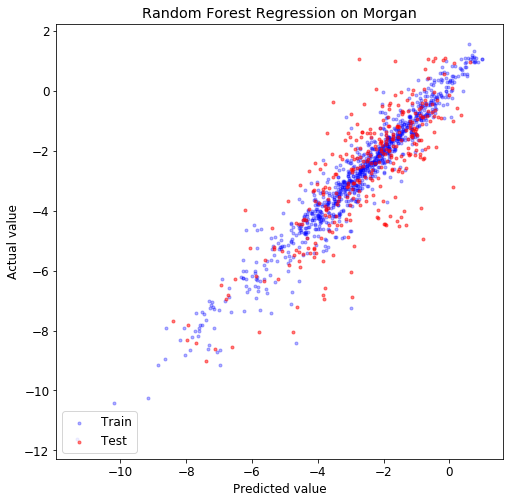

In [28]:
plt.figure(figsize=(8,8))
plt.rcParams["font.size"] = 12
plt.scatter(y_train_pred, y_train, c='blue', marker='.', alpha=0.3, label='Train')
plt.scatter(y_pred, y_test, c='red', marker='.', alpha=0.5, label='Test')
plt.xlabel('Predicted value')
plt.ylabel('Actual value')
plt.title('Random Forest Regression on Morgan')
plt.legend(loc='lower left')
#plt.hlines(y=0, xmin=1, xmax=7, lw=2, color='black')
plt.show()

In [29]:
param_grid = { "max_depth": [2,5,10, None],
                "n_estimators": [10,50,100,300],
                "max_features": [1, 3, 10],
                "min_samples_split": [2, 3, 10],
                "min_samples_leaf": [1, 3, 10]
}

In [30]:
RF_grid = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=5, n_jobs=8, verbose=1)
RF_grid.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done 352 tasks      | elapsed:    9.3s
[Parallel(n_jobs=8)]: Done 852 tasks      | elapsed:   22.5s
[Parallel(n_jobs=8)]: Done 1552 tasks      | elapsed:   42.2s
[Parallel(n_jobs=8)]: Done 2081 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 2160 out of 2160 | elapsed:  1.1min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'max_depth': [2, 5, 10, None], 'n_estimators': [10, 50, 100, 300], 'max_features': [1, 3, 10], 'min_samples_split': [2, 3, 10], 'min_samples_leaf': [1, 3, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [31]:
RF_grid.best_params_

{'max_depth': None,
 'max_features': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [32]:
RF_grid.best_estimator_.fit(X_train, y_train)
y_train_pred = RF_grid.best_estimator_.predict(X_train)
y_test_pred = RF_grid.best_estimator_.predict(X_test)

print('MSE train : %.3f, test : %.3f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)) )
print('R2 train : %.3f, test : %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)) )

MSE train : 0.212, test : 1.193
R2 train : 0.949, test : 0.700


# DeepChem

In [24]:
import os
import deepchem as dc
from deepchem.models.tensorgraph.models.graph_models import GraphConvModel

/home/honda/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
graph_featurizer = dc.feat.graph_features.ConvMolFeaturizer()
loader = dc.data.data_loader.CSVLoader( tasks=['lipid_solubility'], smiles_field="SMILES", featurizer=graph_featurizer )
trainset = loader.featurize( './data_train.csv' )
testset = loader.featurize( './data_test.csv' )